In [1]:
%load_ext watermark


In [2]:
import itertools as it

import alifedata_phyloinformatics_convert as apc
import covasim as cv
from hstrat import _auxiliary_lib as hstrat_aux
from IPython.core.display import display, HTML
from matplotlib import patches as mpl_patches
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from slugify import slugify
from teeplot import teeplot as tp

from pylib._cv_infection_log_to_alstd_df import cv_infection_log_to_alstd_df
from pylib._draw_biophylo import draw_biophylo
from pylib._generate_dummy_sequences_phastSim import (
    generate_dummy_sequences_phastSim,
)
from pylib._mask_mutations import mask_mutations
from pylib._mwu_kdeplot import mwu_kdeplot
from pylib._screen_mutation_defined_nodes import screen_mutation_defined_nodes
from pylib._seed_global_rngs import seed_global_rngs
from pylib._SyncHostCompartments import SyncHostCompartments
from pylib._VariantFlavor import VariantFlavor


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-05-15T15:25:42.211373+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1027-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

matplotlib                        : 3.9.2
numpy                             : 2.1.2
alifedata_phyloinformatics_convert: 0.19.3
hstrat                            : 1.20.11
scipy                             : 1.14.1
teeplot                           : 1.4.2
covasim                           : 3.1.6
seaborn                           : 0.13.2
pandas                            : 2.2.3

Watermark: 2.4.3



In [4]:
teeplot_subdir = "2025-04-11-dev-sequenceconfig"
teeplot_subdir


'2025-04-11-dev-sequenceconfig'

## Setup CovaSim Params

Define `gamma` and `delta` strains, as well as accompanying lower-transmissibility `gamma'` and `delta'` strains.


In [5]:
pop_size = 20_000
num_days = 200
seed_global_rngs(1)


In [6]:
# from https://github.com/InstituteforDiseaseModeling/covasim/blob/fef033fed5a0ca71be9c4f773d75dce1d237e753/covasim/parameters.py
gamma = dict(
    rel_beta=2.05,  # Estimated to be 1.7-2.4-fold more transmissible than wild-type: https://science.sciencemag.org/content/early/2021/04/13/science.abh2644
    rel_symp_prob=1.0,
    rel_severe_prob=2.6,  # From https://www.eurosurveillance.org/content/10.2807/1560-7917.ES.2021.26.16.2100348
    rel_crit_prob=1.0,
    rel_death_prob=1.0,
)
gamma_ = {**gamma, "rel_beta": 1.0}  # lower-transmissibility variant

delta = dict(
    rel_beta=2.2,  # Estimated to be 1.25-1.6-fold more transmissible than B117: https://www.researchsquare.com/article/rs-637724/v1
    rel_symp_prob=1.0,
    rel_severe_prob=3.2,  # 2x more transmissible than alpha from https://mobile.twitter.com/dgurdasani1/status/1403293582279294983
    rel_crit_prob=1.0,
    rel_death_prob=1.0,
)
delta_ = {**delta, "rel_beta": 1.2}  # lower-transmissibility variant


In [7]:
reference_sequences = pd.read_csv("https://osf.io/hp25c/download")
sequence_lookup = dict(
    zip(
        reference_sequences["WHO Label"].values,
        # remove whitespace pollution
        # only use first 100 characters of the sequence, for perf/memory
        reference_sequences["Aligned Sequence"]
        .str.replace(r"\s+", "", regex=True)
        .str.slice(0, 100)
        .values,
    ),
)
variant_flavors = [
    VariantFlavor(
        variant_wt=cv.variant(
            variant=gamma, label="Gamma+", days=0, n_imports=10
        ),
        variant_mut=cv.variant(
            variant=gamma_, label="Gamma'", days=0, n_imports=0
        ),
        withinhost_r_wt=2.0,
        withinhost_r_mut=3.0,
        active_strain_factor_wt=1.5,
        active_strain_factor_mut=1.0,
        p_wt_to_mut=0.05,
        label="Gamma",
        sequence=sequence_lookup["Gamma"],
    ),
    VariantFlavor(
        variant_wt=cv.variant(
            variant=delta, label="Delta+", days=30, n_imports=50
        ),
        variant_mut=cv.variant(
            variant=delta_, label="Delta'", days=0, n_imports=0
        ),
        withinhost_r_wt=2.0,
        withinhost_r_mut=3.0,
        active_strain_factor_wt=1.5,
        active_strain_factor_mut=1.0,
        p_wt_to_mut=0.05,
        label="Delta",
        sequence=sequence_lookup["Delta"],
    ),
]


## Run Example Simulation


In [8]:
sim = cv.Sim(
    interventions=[
        SyncHostCompartments(
            variant_flavors=variant_flavors,
            pop_size=pop_size,
        ),
    ],
    n_days=num_days,
    # adapted from https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_immunity.html
    nab_decay=dict(
        form="nab_growth_decay",
        growth_time=21,
        decay_rate1=0.1,
        decay_time1=47,
        decay_rate2=0.05,
        decay_time2=106,
    ),
    pop_infected=0,  # disable wild-type strain
    pop_size=pop_size,
    variants=[
        v for vf in variant_flavors for v in (vf.variant_wt, vf.variant_mut)
    ],
    rand_seed=1,
)
sim.run()


Initializing sim with 20000 people for 200 days
  Running 2020-03-01 ( 0/200) (0.08 s)  ———————————————————— 0%
  Running 2020-03-11 (10/200) (0.18 s)  •——————————————————— 5%
  Running 2020-03-21 (20/200) (0.29 s)  ••—————————————————— 10%
  Running 2020-03-31 (30/200) (0.40 s)  •••————————————————— 15%
  Running 2020-04-10 (40/200) (0.56 s)  ••••———————————————— 20%
  Running 2020-04-20 (50/200) (0.77 s)  •••••——————————————— 25%
  Running 2020-04-30 (60/200) (1.00 s)  ••••••—————————————— 30%
  Running 2020-05-10 (70/200) (1.22 s)  •••••••————————————— 35%
  Running 2020-05-20 (80/200) (1.43 s)  ••••••••———————————— 40%
  Running 2020-05-30 (90/200) (1.64 s)  •••••••••——————————— 45%
  Running 2020-06-09 (100/200) (1.84 s)  ••••••••••—————————— 50%
  Running 2020-06-19 (110/200) (2.04 s)  •••••••••••————————— 55%
  Running 2020-06-29 (120/200) (2.24 s)  ••••••••••••———————— 60%
  Running 2020-07-09 (130/200) (2.44 s)  •••••••••••••——————— 65%
  Running 2020-07-19 (140/200) (2.66 s) 

Sim(<no label>; 2020-03-01 to 2020-09-17; pop: 20000 random; epi: 48668⚙, 422☠)

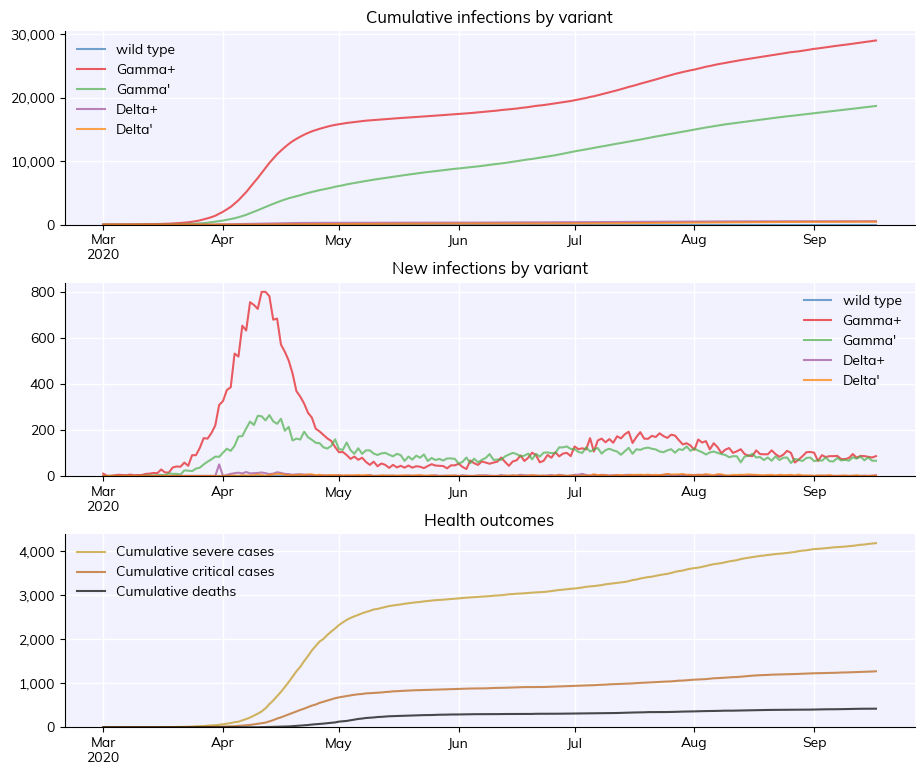

teeplots/2025-04-11-dev-sequenceconfig/viz=plot+what=within-host+ext=.pdf
teeplots/2025-04-11-dev-sequenceconfig/viz=plot+what=within-host+ext=.png


<Figure size 640x480 with 0 Axes>

Ellipsis

In [9]:
tp.tee(
    sim.plot,
    "variant",
    teeplot_outattrs={"what": "within-host"},
    teeplot_subdir=teeplot_subdir,
)
...


## Visualize Pathogen Phylogeny


In [10]:
phylo_df = cv_infection_log_to_alstd_df(sim.people.infection_log)

phylo_df = hstrat_aux.alifestd_downsample_tips_asexual(
    phylo_df, n_downsample=200
)

phylo_tree = apc.alife_dataframe_to_biopython_tree(
    phylo_df,
    setattrs=["variant"],
    setup_branch_lengths=True,
)

palette = sns.color_palette("Set2", n_colors=len(variant_flavors) * 2).as_hex()
palette_iter = it.cycle(palette)
node_colors = {
    variant.label: next(palette_iter)
    for vf in variant_flavors
    for variant in (vf.variant_wt, vf.variant_mut)
}
for node in phylo_tree.find_clades():
    node.color = node_colors[node.variant]


2025-04-11-dev-sequenceconfig/viz=draw-biophylo+what=within-host+ext=.pdf
2025-04-11-dev-sequenceconfig/viz=draw-biophylo+what=within-host+ext=.png


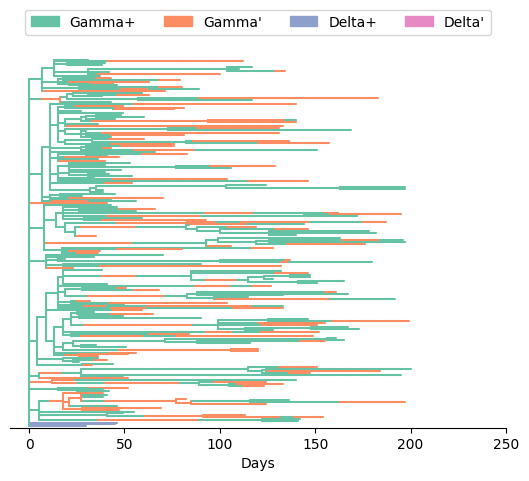

In [11]:
with tp.teed(
    draw_biophylo,
    phylo_tree,
    teeplot_outattrs={"what": "within-host"},
    teeplot_outdir=teeplot_subdir,
) as ax:
    ax.set_xlabel("Days")
    ax.yaxis.set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    legend_handles = [
        mpl_patches.Patch(color=color, label=variant)
        for variant, color in node_colors.items()
    ]
    ax.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=4,
    )


## Extract Pathogen Phylogeny Topology


In [12]:
phylo_df = cv_infection_log_to_alstd_df(sim.people.infection_log)
phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)


In [13]:
# clean tree topology
with hstrat_aux.log_context_duration(
    "alifestd_add_inner_leaves",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_add_inner_leaves(phylo_df, mutate=True)
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_downsample_tips_asexual",
    logger=print,
):
    # phylo_df = hstrat_aux.alifestd_downsample_tips_asexual(
    #     phylo_df,
    #     n_downsample=2_000,
    # )
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_splay_polytomies",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_splay_polytomies(phylo_df, mutate=True)
    phylo_df.drop(columns=["is_leaf"], inplace=True, errors="ignore")
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_collapse_unifurcations",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_collapse_unifurcations(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

with hstrat_aux.log_context_duration(
    "alifestd_delete_unifurcating_roots_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_delete_unifurcating_roots_asexual(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_to_working_format(phylo_df, mutate=True)

# more statistics
with hstrat_aux.log_context_duration("alifestd_mark_*", logger=print):
    phylo_df = hstrat_aux.alifestd_mark_leaves(phylo_df, mutate=True)
    phylo_df = hstrat_aux.alifestd_mark_num_leaves_sibling_asexual(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_mark_num_leaves_asexual(
        phylo_df, mutate=True
    )
    phylo_df = hstrat_aux.alifestd_mark_roots(phylo_df, mutate=True)

phylo_df["is_leaf"].value_counts()


enter log_context_duration for alifestd_add_inner_leaves
exit log_context_duration for alifestd_add_inner_leaves
!!! {"alifestd_add_inner_leaves": 0.014603376388549805}
enter log_context_duration for alifestd_downsample_tips_asexual
exit log_context_duration for alifestd_downsample_tips_asexual
!!! {"alifestd_downsample_tips_asexual": 0.0002193450927734375}
enter log_context_duration for alifestd_splay_polytomies
exit log_context_duration for alifestd_splay_polytomies
!!! {"alifestd_splay_polytomies": 3.1742591857910156}
enter log_context_duration for alifestd_collapse_unifurcations
exit log_context_duration for alifestd_collapse_unifurcations
!!! {"alifestd_collapse_unifurcations": 0.42256760597229004}
enter log_context_duration for alifestd_delete_unifurcating_roots_asexual
exit log_context_duration for alifestd_delete_unifurcating_roots_asexual
!!! {"alifestd_delete_unifurcating_roots_asexual": 0.22104883193969727}
enter log_context_duration for alifestd_mark_*
exit log_context_dura

is_leaf
True     48668
False    48667
Name: count, dtype: int64

## Compute Sister Statistics


In [14]:
min_leaves = 4
work_mask = (phylo_df["num_leaves"] > min_leaves) & (
    phylo_df["num_leaves_sibling"] > min_leaves
)
# sister statistics
with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_subtended_duration_ratio_sister_asexual",
    logger=print,
):
    phylo_df = (
        hstrat_aux.alifestd_mark_clade_subtended_duration_ratio_sister_asexual(
            phylo_df, mutate=True
        )
    )
    phylo_df["clade duration ratio"] = np.log(
        phylo_df["clade_subtended_duration_ratio_sister"]
    )

with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_logistic_growth_sister_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_mark_clade_logistic_growth_sister_asexual(
        phylo_df, mutate=True, parallel_backend="loky", work_mask=work_mask
    )
    phylo_df["clade growth ratio"] = phylo_df["clade_logistic_growth_sister"]

with hstrat_aux.log_context_duration(
    "alifestd_mark_clade_leafcount_ratio_sister_asexual",
    logger=print,
):
    phylo_df = hstrat_aux.alifestd_mark_clade_leafcount_ratio_sister_asexual(
        phylo_df, mutate=True
    )
    phylo_df["clade size ratio"] = np.log(
        phylo_df["clade_leafcount_ratio_sister"]
    )


enter log_context_duration for alifestd_mark_clade_subtended_duration_ratio_sister_asexual


/usr/local/lib/python3.10/dist-packages/hstrat/_auxiliary_lib/_alifestd_mark_clade_subtended_duration_ratio_sister_asexual.py:52: RuntimeWarning: divide by zero encountered in divide
  phylogeny_df["clade_subtended_duration"].values
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


exit log_context_duration for alifestd_mark_clade_subtended_duration_ratio_sister_asexual
!!! {"alifestd_mark_clade_subtended_duration_ratio_sister_asexual": 0.5755383968353271}
enter log_context_duration for alifestd_mark_clade_logistic_growth_sister_asexual
exit log_context_duration for alifestd_mark_clade_logistic_growth_sister_asexual
!!! {"alifestd_mark_clade_logistic_growth_sister_asexual": 7.589587926864624}
enter log_context_duration for alifestd_mark_clade_leafcount_ratio_sister_asexual
exit log_context_duration for alifestd_mark_clade_leafcount_ratio_sister_asexual
!!! {"alifestd_mark_clade_leafcount_ratio_sister_asexual": 0.02389216423034668}


## Generate Pathogen Dummy Sequences


In [15]:
# strip whtiespace
phylo_df.reset_index(drop=True, inplace=True)

phylo_df["variant_flavor"] = phylo_df["variant"].map(
    {
        v.label: vf.label
        for vf in variant_flavors
        for v in (vf.variant_mut, vf.variant_wt)
    },
)
# root (topologically sorted)
ancestral_variant_flavor = phylo_df.at[0, "variant_flavor"]
ancestral_sequence = sequence_lookup[ancestral_variant_flavor]

dummy_sequences = generate_dummy_sequences_phastSim(
    phylo_df,
    ancestral_sequences=sequence_lookup,
)
dummy_sequences["variant"] = dummy_sequences["id"].map(
    phylo_df.set_index("id")["variant"].to_dict(),
)

ancestral_sequence = "A" + ancestral_sequence
dummy_sequences["sequence"] = (
    dummy_sequences["variant"]
    .str.contains("'")
    .map(
        {
            True: "X",
            False: "A",
        },
    )
    + dummy_sequences["sequence"]
)

display(dummy_sequences.head())


enter log_context_duration for remove dashes
exit log_context_duration for remove dashes
!!! {"remove dashes": 1.52587890625e-05}
len(phylogeny_df)=95365, len(ancestral_sequence)=76
enter log_context_duration for alifestd_as_newick_asexual
exit log_context_duration for alifestd_as_newick_asexual
!!! {"alifestd_as_newick_asexual": 0.27263498306274414}
enter log_context_duration for _do_run_phastSim
!!! {"phastSimRun": 0.004088640213012695}
!!! {"init_...": 0.0007710456848144531}
!!! {"ete3Tree": 1.1782886981964111}
!!! {"GenomeTree_hierarchical": 0.0005612373352050781}
!!! {"mutateBranchETEhierarchy": 0.5129494667053223}
!!! {"write_genome_short": 0.06590771675109863}
!!! {"writeGenomeNoIndels": 0.08679890632629395}
!!! {"pl.DataFrame": 0.020262956619262695}
exit log_context_duration for _do_run_phastSim
!!! {"_do_run_phastSim": 1.873861312866211}
enter log_context_duration for restore dashes
exit log_context_duration for restore dashes
!!! {"restore dashes": 0.021962881088256836}
enter

,id,sequence,variant
0,97334,A------------------------GAACAAACCAACCAACTTTCG...,Gamma+
1,97331,A------------------------GAACAAACCAACCAACTTTCG...,Gamma+
2,97330,A------------------------GAACAAACCAACCAACTTTCG...,Gamma+
3,67606,A------------------------GAACAAACCAACCAACTTTCG...,Gamma+
4,67605,A------------------------GAACAAACCAACCAACTTTCG...,Gamma+


## Extract Mutation Masks, Identify Mutaiton-Defined Clades


In [16]:
mutation_masks = mask_mutations(
    ancestral_sequence=ancestral_sequence,
    derived_sequences=dummy_sequences["sequence"],
)

# convert leaf masks to phylo masks
for k, v in mutation_masks.items():  # leaf masks
    phylo_mask = np.zeros(len(phylo_df), dtype=bool)
    phylo_mask[dummy_sequences.loc[v, "id"].values] = True
    mutation_masks[k] = phylo_mask


## Helper Functions to Visualize Screened Mutations


In [17]:
# draw screened phylogeny, color by clades
def draw_screened_phylo_color_by_clades(
    phylo_df: pd.DataFrame, *, mutation: tuple, screen_result: dict
) -> None:
    draw_df = phylo_df.copy()
    draw_df["is_defining"] = screen_result["combined"]
    draw_df = hstrat_aux.alifestd_mask_descendants_asexual(
        draw_df, ancestor_mask=screen_result["combined"], mutate=True
    )
    draw_df["is_screened"] = draw_df["alifestd_mask_descendants_asexual"]
    draw_df["extant"] = draw_df["is_screened"]
    draw_df = hstrat_aux.alifestd_prune_extinct_lineages_asexual(draw_df)
    draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
    draw_df = hstrat_aux.alifestd_collapse_unifurcations(draw_df)
    draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
    print(f"{len(draw_df)=}")
    draw_tree = apc.alife_dataframe_to_biopython_tree(
        draw_df,
        setattrs=["variant", "is_defining"],
        setup_branch_lengths=True,
    )
    if draw_tree is None:
        print("No tree")
        return
    for node in draw_tree.find_clades():
        node.color = [
            node_colors[node.variant],
            node_colors[node.variant],
            # "magenta",
        ][node.is_defining]

    with tp.teed(
        draw_biophylo,
        draw_tree,
        label_func=lambda node: [None, "X"][node.is_defining],
        teeplot_outattrs={
            "color": "defining-mut-clades",
            "what": slugify(str(mutation)),
        },
        teeplot_outdir=teeplot_subdir,
    ) as ax:
        ax.set_xlabel("Days")
        ax.yaxis.set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        legend_handles = [
            mpl_patches.Patch(color=color, label=variant)
            for variant, color in node_colors.items()
        ]
        ax.legend(
            handles=legend_handles,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.15),
            ncol=4,
        )


In [18]:
# draw screened phylogeny, color by screened status
def draw_screened_phylo_color_by_screened_status(
    phylo_df: pd.DataFrame, *, mutation: tuple, screen_result: dict
) -> None:
    draw_df = phylo_df.copy()
    draw_df = hstrat_aux.alifestd_mask_descendants_asexual(
        draw_df,
        ancestor_mask=screen_result["combined"],
        mutate=True,
    )
    draw_df["is_screened"] = draw_df["alifestd_mask_descendants_asexual"]
    draw_df = hstrat_aux.alifestd_mask_descendants_asexual(
        draw_df,
        ancestor_mask=screen_result["combined"][draw_df["sister_id"]],
        mutate=True,
    )
    draw_df["sister_screened"] = draw_df["alifestd_mask_descendants_asexual"]
    draw_df["extant"] = draw_df["is_screened"] | draw_df["sister_screened"]
    draw_df = hstrat_aux.alifestd_prune_extinct_lineages_asexual(draw_df)
    draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
    draw_df = hstrat_aux.alifestd_collapse_unifurcations(draw_df)
    draw_df = hstrat_aux.alifestd_to_working_format(draw_df)
    print(f"{len(draw_df)=}")
    draw_tree = apc.alife_dataframe_to_biopython_tree(
        draw_df,
        setattrs=["is_screened", "sister_screened"],
        setup_branch_lengths=True,
    )
    if draw_tree is None:
        print("No tree")
        return

    for node in draw_tree.find_clades():
        node.color = [["black", "red"], ["blue", "green"],][
            node.is_screened
        ][node.sister_screened]

    with tp.teed(
        draw_biophylo,
        draw_tree,
        teeplot_outattrs={
            "color": "screened-sister",
            "what": slugify(str(mutation)),
        },
        teeplot_outdir=teeplot_subdir,
    ) as ax:
        ax.set_xlabel("Days")
        ax.yaxis.set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        legend_handles = [
            mpl_patches.Patch(color=color, label=variant)
            for variant, color in {
                "is_screened": "blue",
                "sister_screened": "red",
            }.items()
        ]
        ax.legend(
            handles=legend_handles,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.15),
            ncol=2,
        )


In [19]:
# plot distributions
def plot_screened_vs_background_distributions(
    phylo_df: pd.DataFrame, *, min_leaves: int, **kwargs: dict
) -> plt.Figure:
    data_df = phylo_df.copy()
    screen_clade_size = (data_df["num_leaves"] > min_leaves) & (
        data_df["num_leaves_sibling"] > min_leaves
    )
    data_df = data_df[screen_clade_size & ~data_df["is_root"]].copy()

    fig, axs = plt.subplots(
        nrows=2,
        ncols=4,
        figsize=(8, 3),
        gridspec_kw={"height_ratios": [0.5, 1]},
    )

    mwu_kdeplot(
        data_df,
        x="clade duration ratio",
        ax=axs[1, 0],
        legend=False,
        **kwargs,
    )

    mwu_kdeplot(
        data_df,
        x="clade growth ratio",
        ax=axs[1, 1],
        legend=False,
        **kwargs,
    )
    mwu_kdeplot(
        data_df,
        x="clade size ratio",
        ax=axs[1, 2],
        legend=False,
        **kwargs,
    )
    mwu_kdeplot(
        data_df,
        x="num_leaves",
        ax=axs[1, 3],
        legend=False,
        log_scale=(True, False),
        **kwargs,
    )
    sns.kdeplot(  # dummy to create legend
        data_df,
        x="num_leaves",
        ax=axs[0, 3],
        legend=True,
        **kwargs,
    )
    sns.move_legend(
        axs[0, 3], "upper center", bbox_to_anchor=(0.5, 1.15), ncol=2
    )
    axs[0, 3].set_ylim(-10, -10)
    axs[0, 3].set_yticklabels([])
    axs[0, 3].set_xlim(-10, -10)
    axs[0, 3].set_xticklabels([])
    axs[0, 3].set_axis_off()

    for col, var in enumerate(
        [
            "clade duration ratio",
            "clade growth ratio",
            "clade size ratio",
        ],
    ):
        data_df[var] = data_df[var] > 0
        sns.histplot(
            data_df,
            hue=var,
            y="screen",
            multiple="fill",
            ax=axs[0, col],
            discrete=True,
            legend=False,
            palette=sns.color_palette("Pastel1", n_colors=2),
        )
        # for var, number true vs number false vs 0.5
        try:
            nobs = int(data_df.loc[data_df["screen"], var].sum())
            ntrial = int(data_df.loc[data_df["screen"], var].count())

            p = scipy_stats.binomtest(nobs, ntrial, p=0.5).pvalue
            if p < 0.0001:
                p = "****"
            elif p < 0.001:
                p = "***"
            elif p < 0.01:
                p = "**"
            elif p < 0.05:
                p = "*"
            else:
                p = "ns"

        except ValueError:
            p = "nan"

        axs[0, col].set_title(
            f"n = {data_df['screen'].sum()} / {data_df['screen'].count()}\n"
            f"{nobs=} {ntrial=}\n"
            f"frac {nobs / (ntrial or 1):.2f}\n"
            f"binom p = {p}",
            fontsize=8,
        )
        axs[0, col].axvline(0.5, ls="--", color="white")
        axs[0, col].set_ylim(-0.5, 1.5)

    for row in range(2):
        for col in range(1, 4):
            axs[row, col].set_ylabel("")
            axs[row, col].set_yticklabels([])

    for col in range(4):
        axs[0, col].set_xlabel("")
        axs[0, col].set_xticklabels([])

    fig.tight_layout()

    return fig


## Process Pathogen Phylogeny Statistics


enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.33030128479003906}
fisher (array([False,  True]), array([93290,  4045]))
naive (array([False,  True]), array([87828,  9507]))
combined (array([False,  True]), array([95135,  2200]))
len(draw_df)=31504
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=0-a-x+ext=.pdf
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=0-a-x+ext=.png


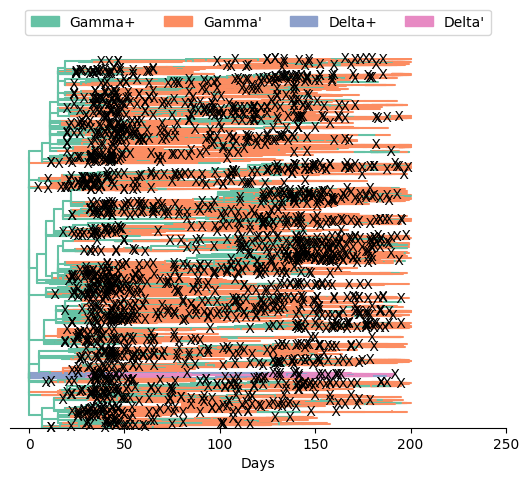

len(draw_df)=89224
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=0-a-x+ext=.pdf
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=0-a-x+ext=.png


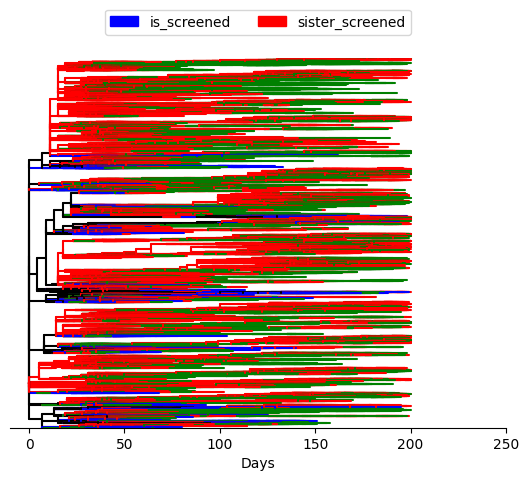

/tmp/ipykernel_4737/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_4737/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-11-dev-sequenceconfig/hue=screen+mutation=0-a-x+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-11-dev-sequenceconfig/hue=screen+mutation=0-a-x+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


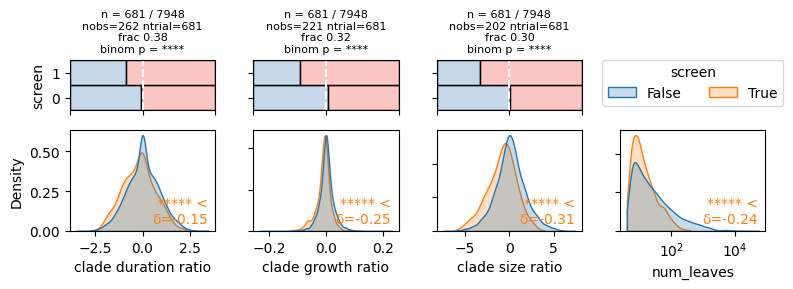

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.14354753494262695}
fisher (array([False,  True]), array([97329,     6]))
naive (array([False,  True]), array([97329,     6]))
combined (array([False,  True]), array([97332,     3]))
len(draw_df)=1976
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=25-g+ext=.pdf
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=25-g+ext=.png


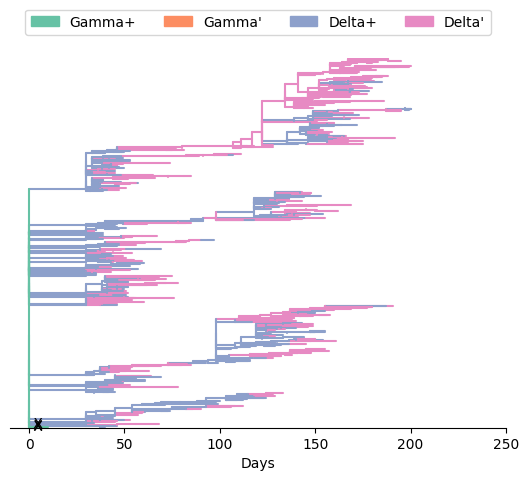

len(draw_df)=8286
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=25-g+ext=.pdf
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=25-g+ext=.png


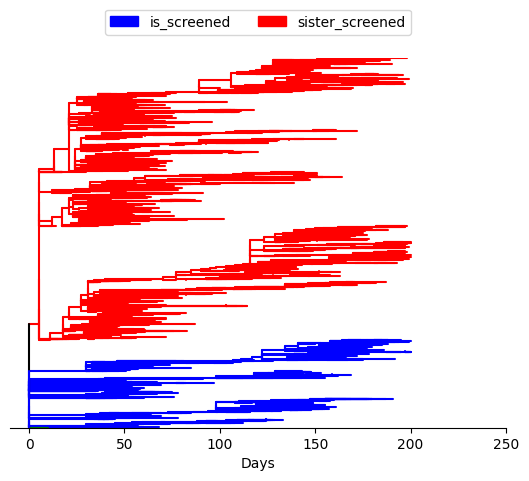

/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping de

2025-04-11-dev-sequenceconfig/hue=screen+mutation=25-g+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-11-dev-sequenceconfig/hue=screen+mutation=25-g+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


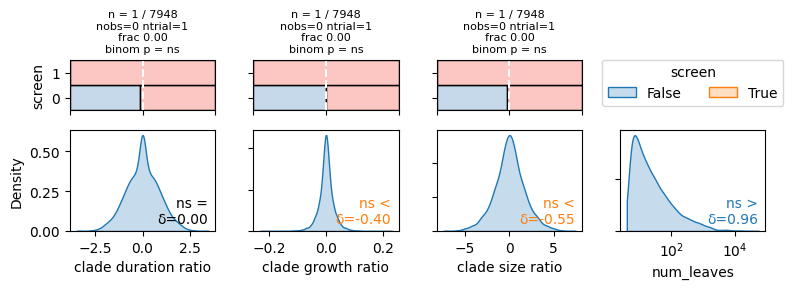

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.12432050704956055}
fisher (array([False,  True]), array([97328,     7]))
naive (array([False,  True]), array([97332,     3]))
combined (array([False,  True]), array([97333,     2]))
len(draw_df)=12
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=25-g-t+ext=.pdf
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=25-g-t+ext=.png


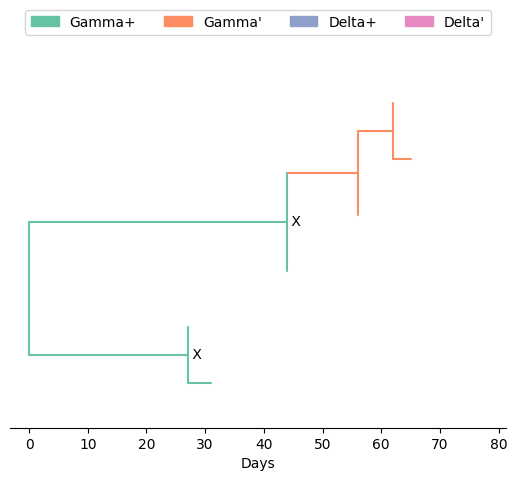

len(draw_df)=76
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=25-g-t+ext=.pdf
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=25-g-t+ext=.png


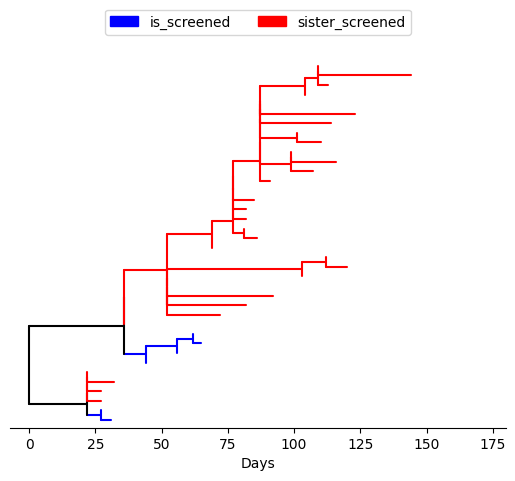

/tmp/ipykernel_4737/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_4737/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-11-dev-sequenceconfig/hue=screen+mutation=25-g-t+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-11-dev-sequenceconfig/hue=screen+mutation=25-g-t+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


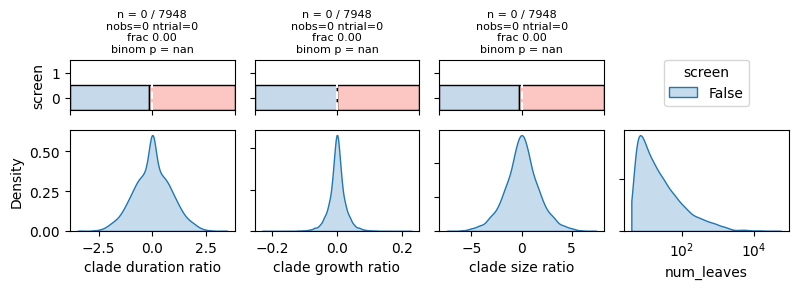

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.1679387092590332}
fisher (array([False,  True]), array([97329,     6]))
naive (array([False,  True]), array([97329,     6]))
combined (array([False,  True]), array([97332,     3]))
len(draw_df)=1976
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=26-a+ext=.pdf
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=26-a+ext=.png


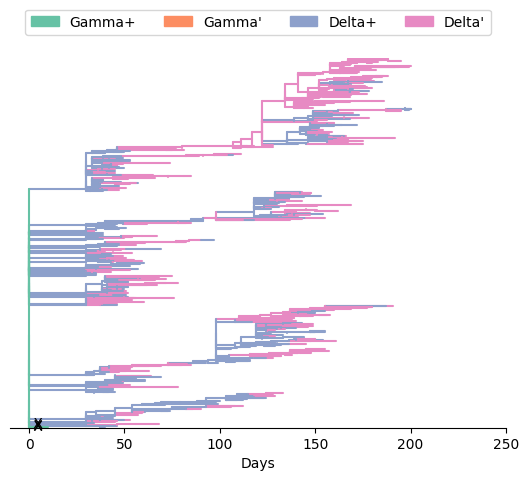

len(draw_df)=8286
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=26-a+ext=.pdf
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=26-a+ext=.png


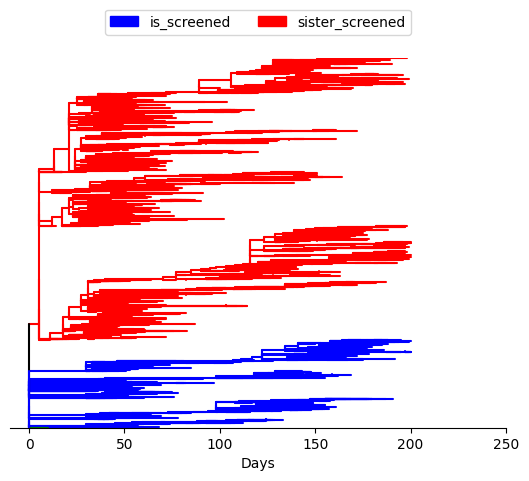

/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping de

2025-04-11-dev-sequenceconfig/hue=screen+mutation=26-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-11-dev-sequenceconfig/hue=screen+mutation=26-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


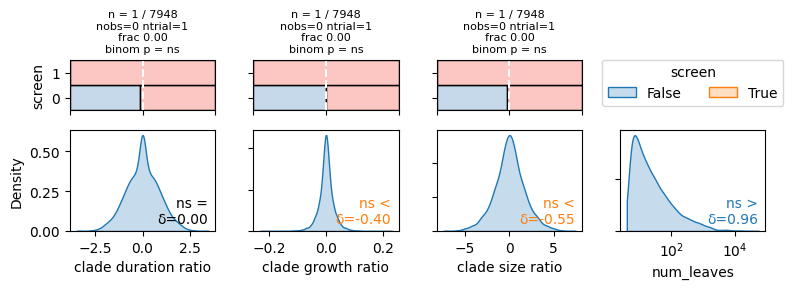

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.11259651184082031}
fisher (array([False,  True]), array([97333,     2]))
naive (array([False,  True]), array([97334,     1]))
combined (array([False,  True]), array([97334,     1]))
len(draw_df)=2
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=26-a-c+ext=.pdf
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=26-a-c+ext=.png


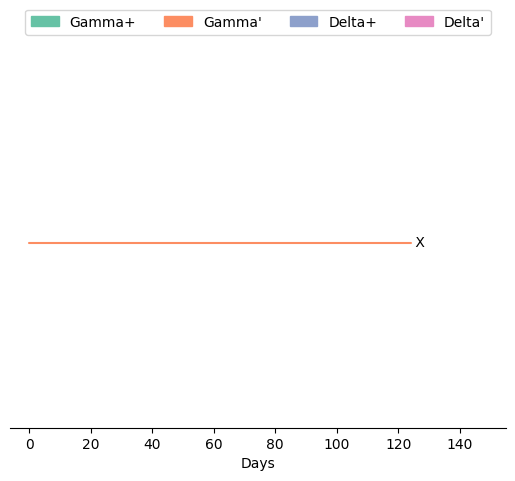

len(draw_df)=86
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=26-a-c+ext=.pdf
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=26-a-c+ext=.png


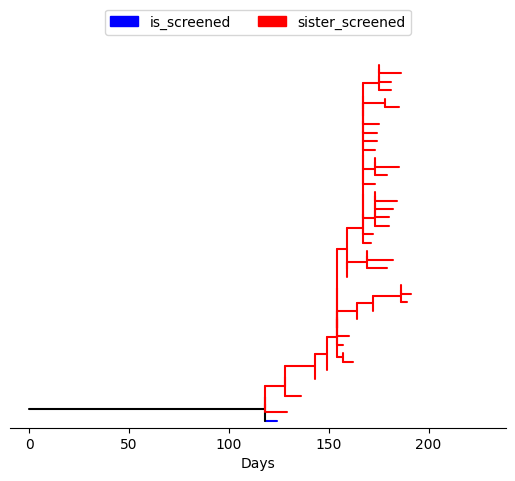

/tmp/ipykernel_4737/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_4737/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-11-dev-sequenceconfig/hue=screen+mutation=26-a-c+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-11-dev-sequenceconfig/hue=screen+mutation=26-a-c+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


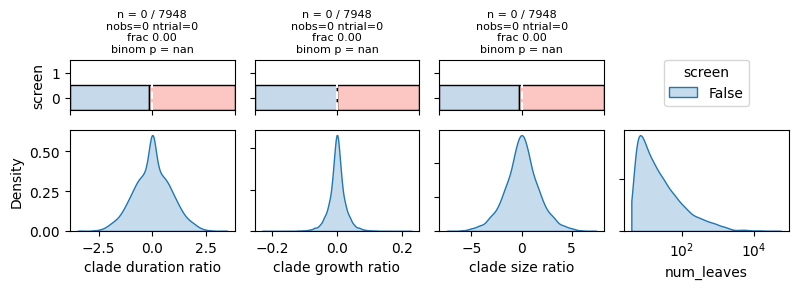

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.09754061698913574}
fisher (array([False,  True]), array([97329,     6]))
naive (array([False,  True]), array([97329,     6]))
combined (array([False,  True]), array([97332,     3]))
len(draw_df)=1976
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=27-a+ext=.pdf
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=27-a+ext=.png


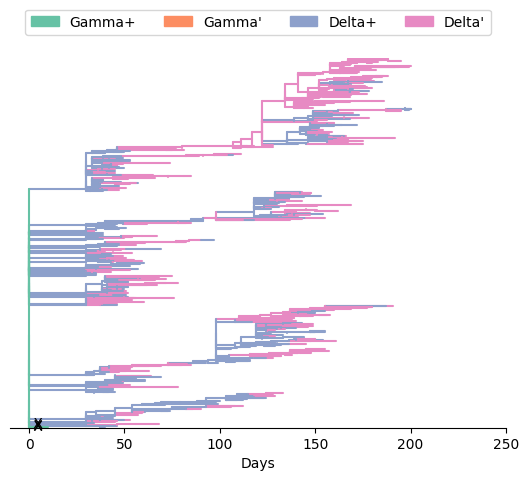

len(draw_df)=8286
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=27-a+ext=.pdf
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=27-a+ext=.png


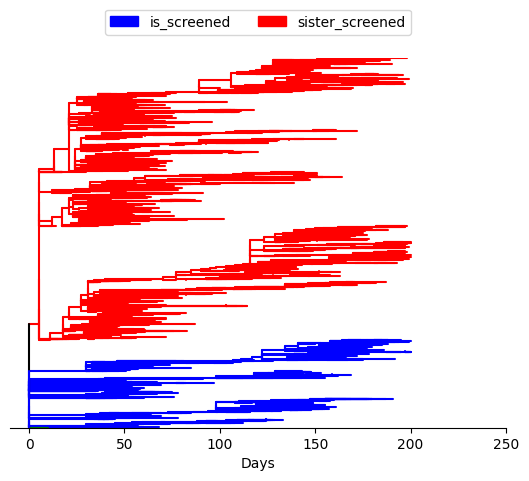

/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping de

2025-04-11-dev-sequenceconfig/hue=screen+mutation=27-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-11-dev-sequenceconfig/hue=screen+mutation=27-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


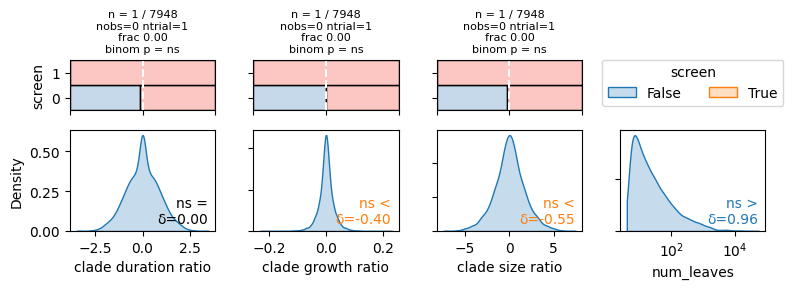

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.1137702465057373}
fisher (array([False,  True]), array([97329,     6]))
naive (array([False,  True]), array([97329,     6]))
combined (array([False,  True]), array([97332,     3]))
len(draw_df)=1976
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=28-c+ext=.pdf
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=28-c+ext=.png


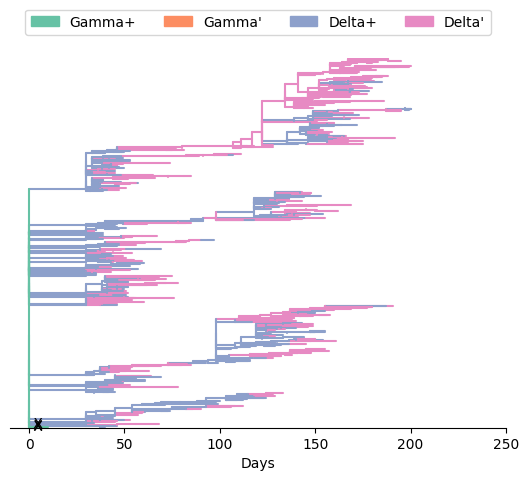

len(draw_df)=8286
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=28-c+ext=.pdf
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=28-c+ext=.png


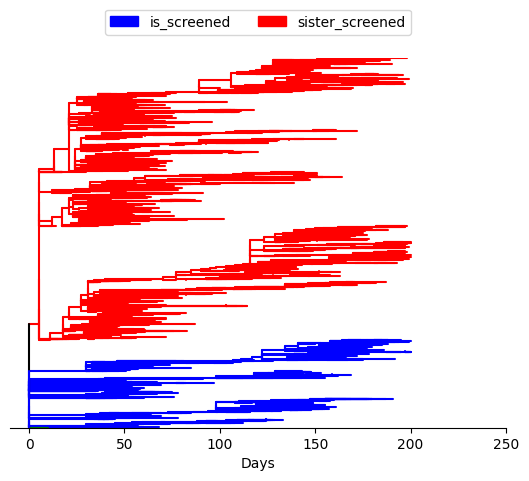

/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping de

2025-04-11-dev-sequenceconfig/hue=screen+mutation=28-c+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-11-dev-sequenceconfig/hue=screen+mutation=28-c+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


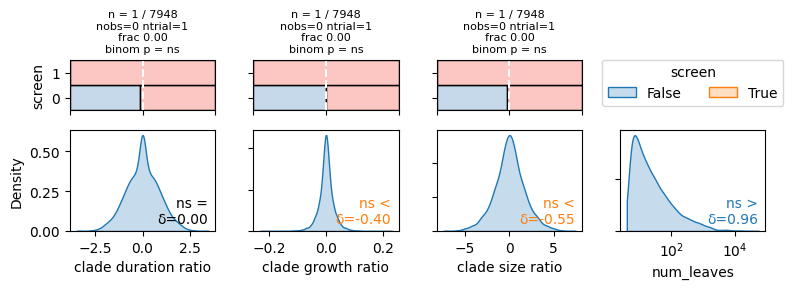

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.08878970146179199}
fisher (array([False,  True]), array([97327,     8]))
naive (array([False,  True]), array([97333,     2]))
combined (array([False,  True]), array([97333,     2]))
len(draw_df)=8
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=28-c-t+ext=.pdf
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=28-c-t+ext=.png


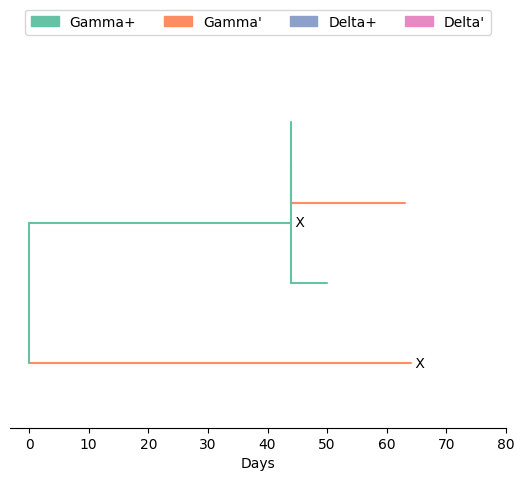

len(draw_df)=66
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=28-c-t+ext=.pdf
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=28-c-t+ext=.png


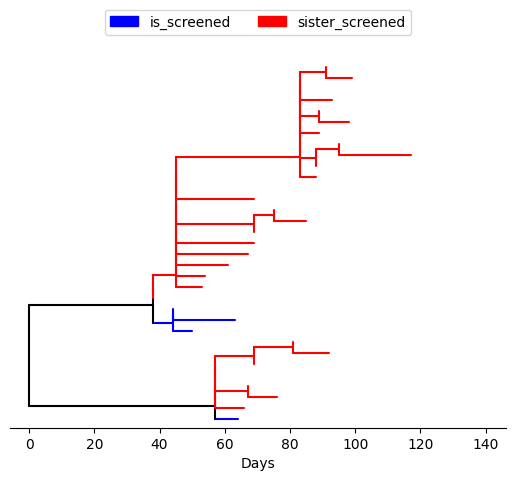

/tmp/ipykernel_4737/2911246713.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0, 3].set_ylim(-10, -10)
/tmp/ipykernel_4737/2911246713.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[0, 3].set_xlim(-10, -10)


2025-04-11-dev-sequenceconfig/hue=screen+mutation=28-c-t+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-11-dev-sequenceconfig/hue=screen+mutation=28-c-t+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


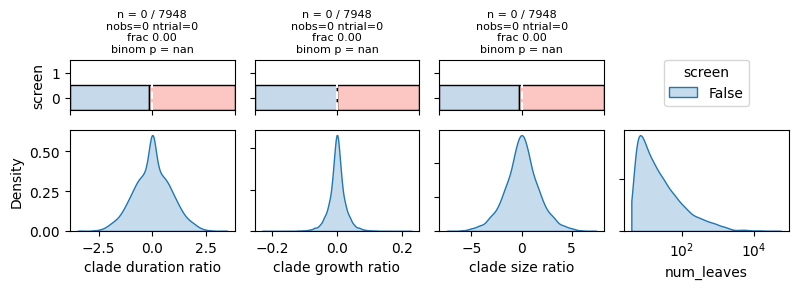

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.09200692176818848}
fisher (array([False,  True]), array([97329,     6]))
naive (array([False,  True]), array([97329,     6]))
combined (array([False,  True]), array([97332,     3]))
len(draw_df)=1976
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=29-a+ext=.pdf
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=29-a+ext=.png


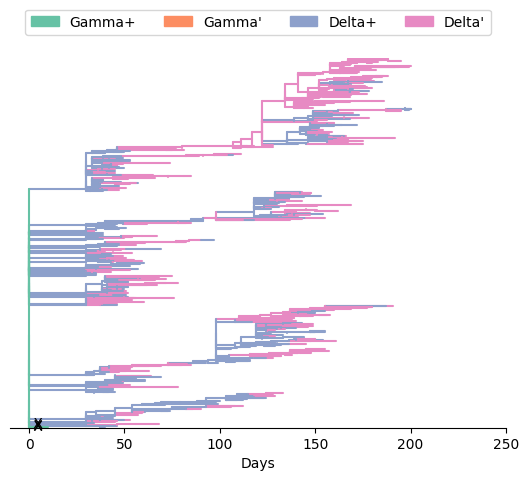

len(draw_df)=8286
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=29-a+ext=.pdf
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=29-a+ext=.png


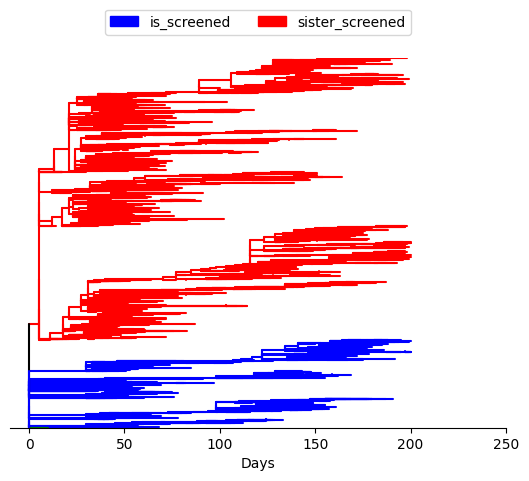

/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping de

2025-04-11-dev-sequenceconfig/hue=screen+mutation=29-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-11-dev-sequenceconfig/hue=screen+mutation=29-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


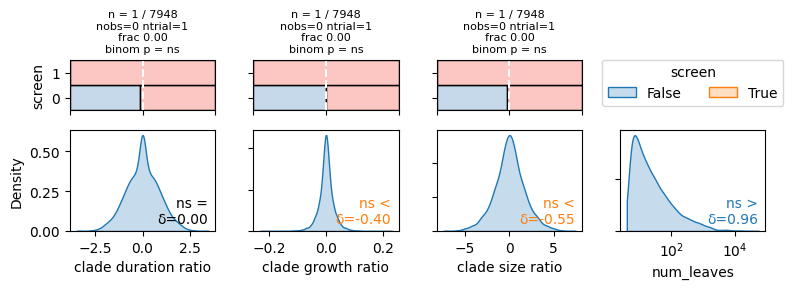

enter log_context_duration for screen_mutation_defined_nodes
exit log_context_duration for screen_mutation_defined_nodes
!!! {"screen_mutation_defined_nodes": 0.08715629577636719}
fisher (array([False,  True]), array([97329,     6]))
naive (array([False,  True]), array([97329,     6]))
combined (array([False,  True]), array([97332,     3]))
len(draw_df)=1976
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=30-a+ext=.pdf
2025-04-11-dev-sequenceconfig/color=defining-mut-clades+viz=draw-biophylo+what=30-a+ext=.png


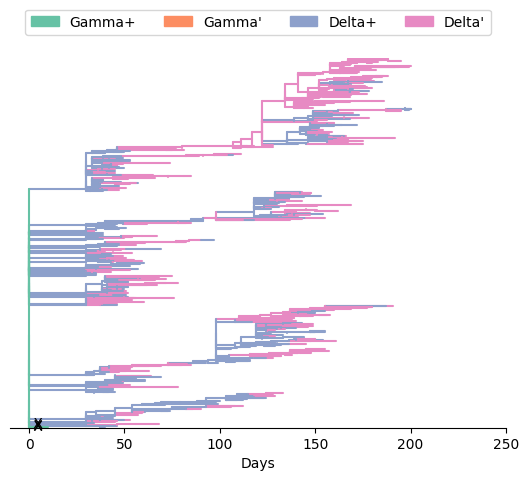

len(draw_df)=8286
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=30-a+ext=.pdf
2025-04-11-dev-sequenceconfig/color=screened-sister+viz=draw-biophylo+what=30-a+ext=.png


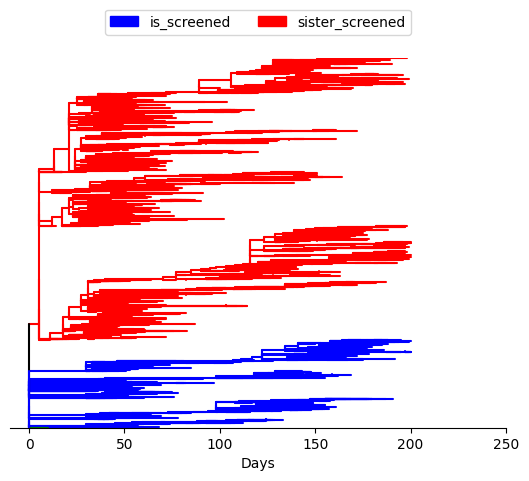

/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=x, hue=hue, ax=ax, **kwargs)
/home/runner/work/multilevel-selection-concept/multilevel-selection-concept/binder/pylib/_mwu_kdeplot.py:34: UserWarning: Dataset has 0 variance; skipping de

2025-04-11-dev-sequenceconfig/hue=screen+mutation=30-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.pdf
2025-04-11-dev-sequenceconfig/hue=screen+mutation=30-a+screen=combined+viz=plot-screened-vs-background-distributions+ext=.png


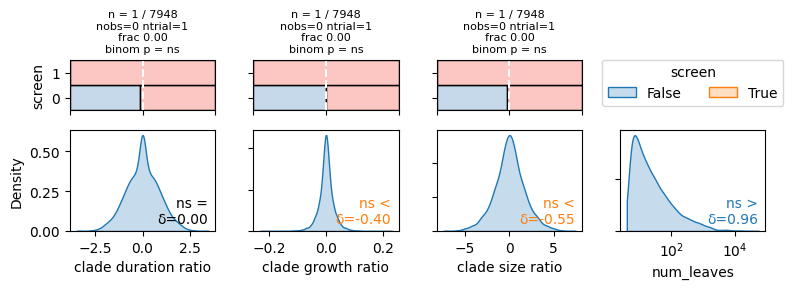

In [20]:
for mutation in it.islice(
    ((site, from_, to) for site, from_, to in mutation_masks),
    10,
):
    display(HTML(f"<h2>{mutation=}</h2>"))

    with hstrat_aux.log_context_duration(
        "screen_mutation_defined_nodes",
        logger=print,
    ):
        screen = screen_mutation_defined_nodes(
            phylo_df.copy(),
            has_mutation=mutation_masks[mutation],
        )

    print("fisher", np.unique(screen["fisher"], return_counts=True))
    print("naive", np.unique(screen["naive"], return_counts=True))
    print("combined", np.unique(screen["combined"], return_counts=True))

    draw_screened_phylo_color_by_clades(
        phylo_df.copy(), mutation=mutation, screen_result=screen
    )
    draw_screened_phylo_color_by_screened_status(
        phylo_df.copy(), mutation=mutation, screen_result=screen
    )

    data_df = phylo_df.copy()
    screen_trait_defined = "combined"
    data_df["screen"] = screen[screen_trait_defined]
    tp.tee(
        plot_screened_vs_background_distributions,
        data_df,
        min_leaves=min_leaves,
        hue="screen",
        common_norm=False,
        cut=True,
        fill=True,
        teeplot_outattrs={
            "mutation": slugify(str(mutation)),
            "screen": screen_trait_defined,
        },
        teeplot_outdir=teeplot_subdir,
    )

    plt.close("all")
    display(HTML("<hr>"))
